Device: cuda

===== (A) BraTS PRETRAIN (binary) =====
[BraTS Dataset] Found 369 folders | Using 368 complete cases | Skipped 1 incomplete cases
[BraTS Pretrain] Epoch 01/10 | Train loss=0.3484 acc=0.7848 | Val loss=2.0343 acc=0.0811 | lr=0.000151
✅ Saved best BraTS pretrain: 0.0811
[BraTS Pretrain] Epoch 02/10 | Train loss=0.2650 acc=0.8758 | Val loss=0.2306 acc=0.9189 | lr=0.000272
✅ Saved best BraTS pretrain: 0.9189
[BraTS Pretrain] Epoch 03/10 | Train loss=0.2544 acc=0.8727 | Val loss=0.2530 acc=0.8649 | lr=0.000239
[BraTS Pretrain] Epoch 04/10 | Train loss=0.2429 acc=0.8606 | Val loss=0.1590 acc=1.0000 | lr=0.000197
✅ Saved best BraTS pretrain: 1.0000
[BraTS Pretrain] Epoch 05/10 | Train loss=0.2078 acc=0.9000 | Val loss=0.2262 acc=0.7838 | lr=0.000151
[BraTS Pretrain] Epoch 06/10 | Train loss=0.2041 acc=0.8939 | Val loss=0.1639 acc=0.9459 | lr=0.000106
[BraTS Pretrain] Epoch 07/10 | Train loss=0.2034 acc=0.8909 | Val loss=0.1847 acc=0.8919 | lr=0.000064
[BraTS Pretrain] Epoch 08/1

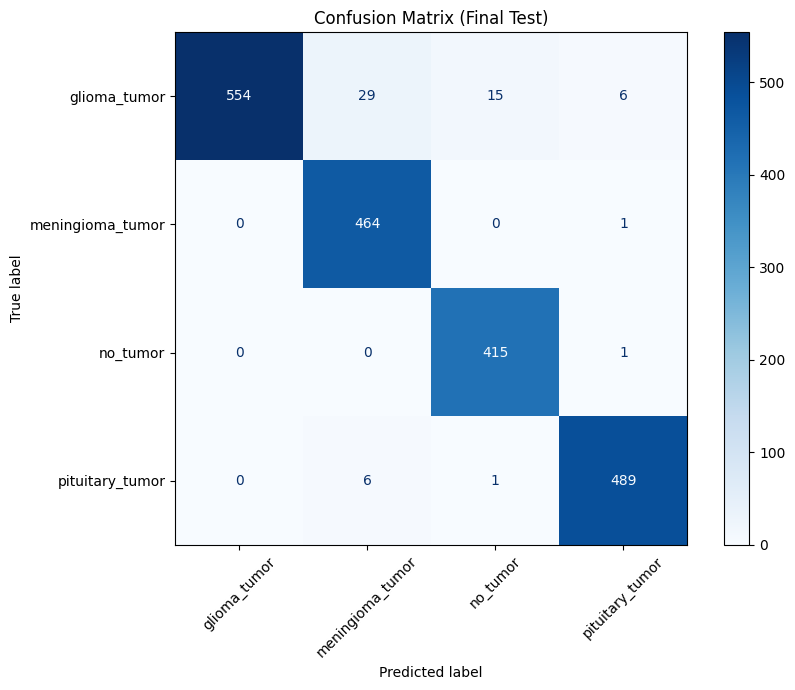


✅ Saved outputs to: /kaggle/working/journal_brats_pretrain_finetune

🎉 Final Test Accuracy: 0.9702


In [ ]:
import os, gc, random, math, warnings
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

try:
    import nibabel as nib
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "nibabel"])
    import nibabel as nib

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


CONFIG = {
    "BRATS_ROOT": "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData",
    "BRATS_MODALITIES": ("flair", "t1ce", "t2"),  # 3 channels
    "BRATS_SEG_NAME": "seg",
    "BRATS_CASE_EXT": ".nii",  

    # -------- Fine-tune dataset (4-class) --------
    "FINETUNE_TRAIN_ROOT": "/kaggle/input/brain-tumor-data-18k/tumordata/Training",
    "FINETUNE_TEST_ROOT":  "/kaggle/input/brain-tumor-data-18k/tumordata/Testing",
    "CLASS_ORDER_4": ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"],

    # -------- Training --------
    "SEED": 42,
    "IMG_SIZE": 224,
    "NUM_WORKERS": 2,

    "PRETRAIN_EPOCHS": 10,
    "PRETRAIN_BS": 10,
    "PRETRAIN_LR": 3e-4,

    "PRETRAIN_ATTEN_MASK_LOSS": True,
    "LAMBDA_ATTEN": 0.30,

    "FINETUNE_EPOCHS": 35,
    "FINETUNE_BS": 12,
    "FINETUNE_LR": 2.5e-4,

    "WEIGHT_DECAY": 1e-4,

    # -------- TTA for evaluation --------
    "USE_TTA": True,
    "TTA_SCALES": [0.95, 1.0, 1.05],
    "TTA_HFLIPS": [False, True],
    "TTA_ROTS": [0, 90, 180, 270],

    # -------- Output --------
    "OUT_DIR": "/kaggle/working/journal_brats_pretrain_finetune",
}

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["SEED"])


def list_subdirs(path):
    return [os.path.join(path, d) for d in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, d))]

def safe_img_list(root):
    image_paths, labels = [], []
    for category in sorted(os.listdir(root)):
        cat_path = os.path.join(root, category)
        if os.path.isdir(cat_path):
            for fn in os.listdir(cat_path):
                fp = os.path.join(cat_path, fn)
                if fp.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                    image_paths.append(fp)
                    labels.append(category)
    return image_paths, labels

def minmax_norm(x, eps=1e-6):
    x = x.astype(np.float32)
    mn, mx = x.min(), x.max()
    if (mx - mn) < eps:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn + eps)

def zscore_norm(x, eps=1e-6):
    x = x.astype(np.float32)
    m, s = x.mean(), x.std()
    if s < eps:
        return np.zeros_like(x, dtype=np.float32)
    return (x - m) / (s + eps)


class FolderClassificationDataset(Dataset):
    """
    root/class_name/*.png|jpg...
    """
    def __init__(self, root, class_order, transform=None):
        self.root = root
        self.class_order = class_order
        self.transform = transform
        self.image_paths, self.labels_str = safe_img_list(root)

        keep = []
        for p, y in zip(self.image_paths, self.labels_str):
            if y in self.class_order:
                keep.append((p, y))
        self.items = keep

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        p, y = self.items[idx]
        img = Image.open(p).convert("RGB")
        label = self.class_order.index(y)
        if self.transform:
            img = self.transform(img)
        return img, label

class BraTSSlicePretrainDataset(Dataset):
    """
    BraTS slice-level dataset:
    returns:
      img: (3,224,224)
      label: 0/1 tumor presence
      mask: (1,224,224) binary (optional)
    Each item is a CASE; __getitem__ randomly samples a slice each call.

    Robust:
    - auto-detects .nii / .nii.gz
    - filters out incomplete cases (missing modalities/seg)
    """
    def __init__(self, brats_root, modalities=("flair","t1ce","t2"), seg_name="seg",
                 img_size=224, tumor_slice_prob=0.7, return_mask=True, verbose=True):
        self.brats_root = brats_root
        self.modalities = modalities
        self.seg_name = seg_name
        self.img_size = img_size
        self.tumor_slice_prob = tumor_slice_prob
        self.return_mask = return_mask
        self.verbose = verbose

        self.case_dirs = [os.path.join(brats_root, d) for d in sorted(os.listdir(brats_root))
                          if os.path.isdir(os.path.join(brats_root, d))]
        if len(self.case_dirs) == 0:
            raise RuntimeError(f"No BraTS case folders found at: {brats_root}")

        # Build a filtered list of valid cases
        valid = []
        skipped = 0
        for cd in self.case_dirs:
            cid = os.path.basename(cd)
            files_ok = True

            # require modalities
            for m in self.modalities:
                if self._find_file(cd, cid, m, allow_missing=True) is None:
                    files_ok = False
                    break

            # require seg if return_mask=True
            if files_ok and self.return_mask:
                if self._find_file(cd, cid, self.seg_name, allow_missing=True) is None:
                    files_ok = False

            if files_ok:
                valid.append((cd, cid))
            else:
                skipped += 1

        self.cases = valid
        if len(self.cases) == 0:
            raise RuntimeError(
                "No valid BraTS cases found after filtering. "
                "Check BRATS_ROOT and file naming."
            )

        if self.verbose:
            print(f"[BraTS Dataset] Found {len(self.case_dirs)} folders | "
                  f"Using {len(self.cases)} complete cases | Skipped {skipped} incomplete cases")

    def __len__(self):
        return len(self.cases)

    def _find_file(self, case_dir, case_id, suffix, allow_missing=False):
        """
        Tries common BraTS patterns:
          {case_id}_{suffix}.nii
          {case_id}_{suffix}.nii.gz
          any file ending with _{suffix}.nii / _{suffix}.nii.gz
        """
        # Exact patterns first
        fp1 = os.path.join(case_dir, f"{case_id}_{suffix}.nii")
        fp2 = os.path.join(case_dir, f"{case_id}_{suffix}.nii.gz")
        if os.path.exists(fp1):
            return fp1
        if os.path.exists(fp2):
            return fp2

        # Fallback: any matching file
        cand = []
        for f in os.listdir(case_dir):
            if f.endswith(f"_{suffix}.nii") or f.endswith(f"_{suffix}.nii.gz"):
                cand.append(os.path.join(case_dir, f))

        if len(cand) > 0:
            return cand[0]

        if allow_missing:
            return None
        raise FileNotFoundError(f"Missing '{suffix}' for case {case_id} in {case_dir}")

    def _load_case_vols(self, case_dir, case_id):
        vols = []
        for m in self.modalities:
            fp = self._find_file(case_dir, case_id, m, allow_missing=False)
            vols.append(nib.load(fp).get_fdata().astype(np.float32))

        seg = None
        if self.return_mask:
            seg_fp = self._find_file(case_dir, case_id, self.seg_name, allow_missing=False)
            seg = nib.load(seg_fp).get_fdata().astype(np.float32)

        return vols, seg

    def _pick_slice_index(self, seg):
        tumor_slices = np.where(seg.sum(axis=(0,1)) > 0)[0]
        D = seg.shape[-1]
        if len(tumor_slices) == 0:
            return random.randint(0, D-1), 0
        if random.random() < self.tumor_slice_prob:
            z = int(np.random.choice(tumor_slices))
            return z, 1
        z = random.randint(0, D-1)
        label = 1 if seg[..., z].sum() > 0 else 0
        return z, label

    def _resize_np(self, arr, size):
        t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0)
        t = F.interpolate(t, size=(size,size), mode="bilinear", align_corners=False)
        return t.squeeze().cpu().numpy().astype(np.float32)

    def _simple_aug(self, img3, mask1=None):
        if random.random() < 0.5:
            img3 = img3[:, :, ::-1].copy()
            if mask1 is not None:
                mask1 = mask1[:, :, ::-1].copy()
        if random.random() < 0.5:
            img3 = img3[:, ::-1, :].copy()
            if mask1 is not None:
                mask1 = mask1[:, ::-1, :].copy()

        k = random.randint(0, 3)
        if k > 0:
            img3 = np.rot90(img3, k=k, axes=(1,2)).copy()
            if mask1 is not None:
                mask1 = np.rot90(mask1, k=k, axes=(1,2)).copy()

        if random.random() < 0.7:
            gain = 0.9 + 0.2 * random.random()
            bias = (random.random() - 0.5) * 0.05
            img3 = np.clip(img3 * gain + bias, 0.0, 1.0)

        return img3, mask1

    def __getitem__(self, idx):
        case_dir, case_id = self.cases[idx]
        vols, seg = self._load_case_vols(case_dir, case_id)

        # seg must exist if return_mask=True
        z, label = self._pick_slice_index(seg)

        chans = []
        for v in vols:
            sl = v[..., z]
            sl = zscore_norm(sl)
            sl = minmax_norm(sl)
            sl = self._resize_np(sl, self.img_size)
            chans.append(sl)
        img = np.stack(chans, axis=0).astype(np.float32)

        mask = None
        if self.return_mask:
            m = (seg[..., z] > 0).astype(np.float32)
            m = self._resize_np(m, self.img_size)
            mask = m[None, ...].astype(np.float32)

        img, mask = self._simple_aug(img, mask)

        img_t = torch.from_numpy(img)
        if self.return_mask:
            mask_t = torch.from_numpy(mask)
            return img_t, torch.tensor(label, dtype=torch.long), mask_t
        return img_t, torch.tensor(label, dtype=torch.long)


def get_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ])
    return train_transform, val_transform


class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        x = F.avg_pool2d(x, (x.size(-2), x.size(-1)))
        return x.pow(1.0 / self.p)

class SEBlock(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        red = max(8, c // r)
        self.fc = nn.Sequential(
            nn.Conv2d(c, red, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(red, c, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(self.pool(x))
        return x * w

class ConvBnAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=None, g=1, dil=1):
        super().__init__()
        if p is None:
            p = dil * (k - 1) // 2
        self.conv = nn.Conv2d(c_in, c_out, kernel_size=k, stride=s, padding=p,
                              groups=g, bias=False, dilation=dil)
        self.bn = nn.BatchNorm2d(c_out)
        self.act = nn.SiLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, d=1):
        super().__init__()
        self.dw = ConvBnAct(c_in, c_in, k=k, s=s, p=None, g=c_in, dil=d)
        self.pw = ConvBnAct(c_in, c_out, k=1, s=1, p=0)
    def forward(self, x):
        return self.pw(self.dw(x))

def gaussian_kernel2d(ks=5, sigma=1.0, device='cpu', dtype=torch.float32):
    ax = torch.arange(ks, device=device, dtype=dtype) - (ks - 1) / 2.0
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

class GaussianBlur2d(nn.Module):
    def __init__(self, channels, ks=5, sigma=1.0):
        super().__init__()
        kernel = gaussian_kernel2d(ks=ks, sigma=sigma)
        weight = kernel.unsqueeze(0).unsqueeze(0)
        self.register_buffer('weight', weight)
        self.channels = channels
        self.ks = ks
        self.pad = ks // 2
    def forward(self, x):
        B, C, H, W = x.shape
        w = self.weight.expand(C, 1, self.ks, self.ks).to(dtype=x.dtype, device=x.device)
        x = F.pad(x, (self.pad, self.pad, self.pad, self.pad), mode='reflect')
        return F.conv2d(x, w, bias=None, stride=1, padding=0, groups=C)

class LaHa(nn.Module):
    def __init__(self, c, r=16, k=7, gauss_ks=5, gauss_sigma=1.0):
        super().__init__()
        assert k in (3, 7)
        self.probe = nn.Conv2d(c, c, kernel_size=1, bias=True)
        self.blur = GaussianBlur2d(c, ks=gauss_ks, sigma=gauss_sigma)
        red = max(8, c // r)
        self.ch_gate = nn.Sequential(
            nn.Conv2d(c*2, red, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(red, c, 1, bias=True),
            nn.Sigmoid()
        )
        pad = 3 if k == 7 else 1
        self.sp_conv = nn.Conv2d(2, 1, kernel_size=k, padding=pad, bias=False)
        self.sp_sig = nn.Sigmoid()
    def forward(self, x):
        p = torch.sigmoid(self.probe(x))
        h = x * p
        h = self.blur(h)
        avg = torch.mean(h, dim=(2, 3), keepdim=True)
        std = torch.sqrt(torch.clamp(torch.var(h, dim=(2, 3), keepdim=True, unbiased=False), min=1e-6))
        cdesc = torch.cat([avg, std], dim=1)
        ch = self.ch_gate(cdesc)
        y = x * ch
        h_avg = torch.mean(h, dim=1, keepdim=True)
        h_max, _ = torch.max(h, dim=1, keepdim=True)
        s = self.sp_sig(self.sp_conv(torch.cat([h_avg, h_max], dim=1)))
        y = y * s
        return y

class ResidualBlock(nn.Module):
    def __init__(self, c, expand=2):
        super().__init__()
        mid = c * expand
        self.block = nn.Sequential(
            ConvBnAct(c, mid, k=1, s=1, p=0),
            DepthwiseSeparableConv(mid, mid, k=3, s=1),
            ConvBnAct(mid, c, k=1, s=1, p=0),
        )
        self.attn = LaHa(c, r=8, k=7)
    def forward(self, x):
        y = self.block(x)
        y = self.attn(y)
        return x + y

class AdaptiveSpiralBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        assert c % 3 == 0, "Channels must be divisible by 3"
        c_g = c // 3
        self.dilation_params = nn.Parameter(torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32))

        self.dw1 = nn.Conv2d(c_g, c_g, kernel_size=3, padding=0, groups=c_g, bias=False)
        self.bn1 = nn.BatchNorm2d(c_g)
        self.dw2 = nn.Conv2d(c_g, c_g, kernel_size=3, padding=0, groups=c_g, bias=False)
        self.bn2 = nn.BatchNorm2d(c_g)
        self.dw3 = nn.Conv2d(c_g, c_g, kernel_size=3, padding=0, groups=c_g, bias=False)
        self.bn3 = nn.BatchNorm2d(c_g)

        self.pw = ConvBnAct(c, c, k=1)
        self.se = SEBlock(c, r=8)

    def _apply_dilated_conv(self, x, conv, bn, dilation):
        dilation = torch.clamp(dilation, 1.0, 5.0)
        d_low = int(torch.floor(dilation).item())
        d_high = int(torch.ceil(dilation).item())
        alpha = float((dilation - d_low).item())

        def run(d):
            pad = d
            x_pad = F.pad(x, (pad, pad, pad, pad), mode="reflect")
            out = F.conv2d(x_pad, conv.weight, stride=1, padding=0, dilation=d, groups=conv.groups)
            return out

        if d_low == d_high:
            out = run(d_low)
        else:
            out_low = run(d_low)
            out_high = run(d_high)
            mh = min(out_low.shape[-2], out_high.shape[-2])
            mw = min(out_low.shape[-1], out_high.shape[-1])
            out = (1 - alpha) * out_low[..., :mh, :mw] + alpha * out_high[..., :mh, :mw]

        return F.silu(bn(out))

    def forward(self, x):
        c_g = x.shape[1] // 3
        x1, x2, x3 = x[:, :c_g], x[:, c_g:2*c_g], x[:, 2*c_g:]

        y1 = self._apply_dilated_conv(x1, self.dw1, self.bn1, self.dilation_params[0])
        y2 = self._apply_dilated_conv(x2, self.dw2, self.bn2, self.dilation_params[1])
        y3 = self._apply_dilated_conv(x3, self.dw3, self.bn3, self.dilation_params[2])

        mh = min(y1.shape[-2], y2.shape[-2], y3.shape[-2])
        mw = min(y1.shape[-1], y2.shape[-1], y3.shape[-1])
        y = torch.cat([y1[..., :mh, :mw], y2[..., :mh, :mw], y3[..., :mh, :mw]], dim=1)

        y = self.pw(y)
        y = self.se(y)

        if x.shape[-2:] != y.shape[-2:]:
            x = x[..., :y.shape[-2], :y.shape[-1]]
        return x + y

class HierarchicalTumorAttention(nn.Module):
    def __init__(self, channels, num_levels=4):
        super().__init__()
        self.num_levels = num_levels
        self.level_attns = nn.ModuleList([self._make_level_attention(channels) for _ in range(num_levels)])

        self.fusion = nn.Sequential(
            nn.Conv2d(channels * num_levels, channels * 2, 1, bias=False),
            nn.BatchNorm2d(channels * 2),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels * 2, channels, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.SiLU(inplace=True)
        )

        self.level_predictor = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, num_levels, 1),
            nn.Softmax(dim=1)
        )

        self.guidance_head = nn.Sequential(
            nn.Conv2d(channels, max(8, channels // 4), 3, padding=1, bias=False),
            nn.BatchNorm2d(max(8, channels // 4)),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(8, channels // 4), 1, 1),
            nn.Sigmoid()
        )

    def _make_level_attention(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, groups=channels, bias=False),
            nn.BatchNorm2d(channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels, channels, 1, bias=False),
            nn.BatchNorm2d(channels),
            SEBlock(channels, r=8)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        level_feats = [m(x) for m in self.level_attns]
        fused = self.fusion(torch.cat(level_feats, dim=1))
        level_w = self.level_predictor(fused)  # (B,L,1,1)

        weighted = 0.0
        for i, feat in enumerate(level_feats):
            weighted = weighted + level_w[:, i:i+1] * feat

        guidance = self.guidance_head(weighted)
        out = x + weighted * guidance
        return out, level_w.squeeze(-1).squeeze(-1), guidance

class CrossScaleAttention(nn.Module):
    def __init__(self, channels=(48, 96, 144, 192), unified_dim=128):
        super().__init__()
        self.channels = list(channels)

        self.projections = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(c, unified_dim, 1, bias=False),
                nn.BatchNorm2d(unified_dim),
                nn.SiLU(inplace=True)
            ) for c in self.channels
        ])

        self.cross_fusion = nn.Sequential(
            nn.Conv2d(unified_dim, unified_dim, 3, padding=1, groups=unified_dim, bias=False),
            nn.BatchNorm2d(unified_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(unified_dim, unified_dim, 1, bias=False),
            nn.BatchNorm2d(unified_dim),
            nn.SiLU(inplace=True)
        )

        self.refinements = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(unified_dim, c, 1, bias=False),
                nn.BatchNorm2d(c),
                nn.SiLU(inplace=True)
            ) for c in self.channels
        ])

        self.scale_weights = nn.Parameter(torch.zeros(len(self.channels)))

    def forward(self, feats):
        target_size = feats[-1].shape[-2:]
        proj = []
        for i, f in enumerate(feats):
            p = self.projections[i](f)
            if p.shape[-2:] != target_size:
                p = F.interpolate(p, size=target_size, mode="bilinear", align_corners=False)
            proj.append(p)
        fused = self.cross_fusion(torch.stack(proj, dim=0).mean(dim=0))

        outs = []
        for i, f in enumerate(feats):
            H, W = f.shape[-2:]
            fr = fused if fused.shape[-2:] == (H, W) else F.interpolate(fused, size=(H, W), mode="bilinear", align_corners=False)
            back = self.refinements[i](fr)
            w = torch.sigmoid(self.scale_weights[i])
            outs.append((1 - w) * f + w * back)
        return outs

class UncertaintyAwareHead(nn.Module):
    def __init__(self, in_features, num_classes, hidden1=768, hidden2=384, dropout=0.35):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features)

        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_features, hidden1, bias=False)
        self.bn1 = nn.BatchNorm1d(hidden1)

        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden1, hidden2, bias=False)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.gate = nn.Sequential(
            nn.Linear(hidden2, hidden2 // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden2 // 2, hidden2),
            nn.Sigmoid()
        )
        self.fc_out = nn.Linear(hidden2, num_classes)

        self.unc_head = nn.Sequential(
            nn.Linear(hidden2, hidden2 // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden2 // 2, num_classes),
            nn.Softplus()
        )

    def forward(self, x, return_uncertainty=False):
        x = self.bn(x)
        h1 = self.dropout1(x)
        h1 = F.gelu(self.bn1(self.fc1(h1)))
        h2 = self.dropout2(h1)
        h2 = F.gelu(self.bn2(self.fc2(h2)))
        g = self.gate(h2)
        logits = self.fc_out(h2 * g)
        unc = self.unc_head(h2)
        if return_uncertainty:
            return logits, unc
        return logits

class Proposed_Model(nn.Module):
    def __init__(self, num_classes, in_ch=3, base_c=48):
        super().__init__()
        c1, c2, c3, c4 = base_c, base_c*2, base_c*3, base_c*4

        self.stem = nn.Sequential(
            ConvBnAct(in_ch, c1, k=3, s=2),
            ConvBnAct(c1, c1, k=3, s=1),
            SEBlock(c1, r=8)
        )

        self.s1a = ResidualBlock(c1)
        self.s1b = ResidualBlock(c1)
        self.s1h = HierarchicalTumorAttention(c1, num_levels=4)
        self.down1 = ConvBnAct(c1, c2, k=3, s=2)

        assert c2 % 3 == 0 and c3 % 3 == 0, "base_c must satisfy divisibility for spiral blocks"
        self.s2a = AdaptiveSpiralBlock(c2)
        self.s2b = AdaptiveSpiralBlock(c2)
        self.s2h = HierarchicalTumorAttention(c2, num_levels=4)
        self.down2 = ConvBnAct(c2, c3, k=3, s=2)

        self.s3a = ResidualBlock(c3)
        self.s3b = AdaptiveSpiralBlock(c3)
        self.s3h = HierarchicalTumorAttention(c3, num_levels=4)
        self.down3 = ConvBnAct(c3, c4, k=3, s=2)

        self.s4a = ResidualBlock(c4)
        self.s4b = ResidualBlock(c4)
        self.s4c = ResidualBlock(c4)
        self.s4h = HierarchicalTumorAttention(c4, num_levels=4)

        self.cross = CrossScaleAttention(channels=(c1, c2, c3, c4), unified_dim=128)

        self.pool_gem = GeM()
        self.pool_max = nn.AdaptiveMaxPool2d(1)
        self.head = UncertaintyAwareHead(c4 * 2, num_classes, hidden1=768, hidden2=384, dropout=0.35)

        self.last_guidance = None
        self.last_level_weights = None

    def forward(self, x, return_guidance=False, return_uncertainty=False):
        x = self.stem(x)

        x = self.s1a(x); x = self.s1b(x)
        f1, w1, g1 = self.s1h(x)

        x = self.down1(f1); x = self.s2a(x); x = self.s2b(x)
        f2, w2, g2 = self.s2h(x)

        x = self.down2(f2); x = self.s3a(x); x = self.s3b(x)
        f3, w3, g3 = self.s3h(x)

        x = self.down3(f3); x = self.s4a(x); x = self.s4b(x); x = self.s4c(x)
        f4, w4, g4 = self.s4h(x)

        f1r, f2r, f3r, f4r = self.cross([f1, f2, f3, f4])

        g_stack = torch.stack([
            F.interpolate(g1, size=g4.shape[-2:], mode="bilinear", align_corners=False),
            F.interpolate(g2, size=g4.shape[-2:], mode="bilinear", align_corners=False),
            F.interpolate(g3, size=g4.shape[-2:], mode="bilinear", align_corners=False),
            g4
        ], dim=1)
        g_agg = g_stack.mean(dim=1)
        self.last_guidance = g_agg
        self.last_level_weights = {"stage1": w1, "stage2": w2, "stage3": w3, "stage4": w4}

        gem = self.pool_gem(f4r).flatten(1)
        gmp = self.pool_max(f4r).flatten(1)
        pooled = torch.cat([gem, gmp], dim=1)

        logits, unc = self.head(pooled, return_uncertainty=True)
        if return_uncertainty and return_guidance:
            return logits, g_agg, unc
        if return_uncertainty:
            return logits, unc
        if return_guidance:
            return logits, g_agg
        return logits

# ============================================================================
# LOSSES + METRICS
# ============================================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)
        if targets.dim() == 1:
            onehot = F.one_hot(targets, num_classes).float()
            targets = onehot * (1 - self.label_smoothing) + (self.label_smoothing / num_classes)

        logp = F.log_softmax(inputs, dim=1)
        p = torch.exp(logp)
        pt = (targets * p).sum(dim=1)

        focal_w = (1 - pt) ** self.gamma
        ce = -(targets * logp).sum(dim=1)
        loss = focal_w * ce

        if self.alpha is not None:
            alpha_t = (targets * self.alpha.unsqueeze(0)).sum(dim=1)
            loss = alpha_t * loss

        return loss.mean()

def calculate_class_weights_from_folder(root, class_order, device):
    counts = torch.zeros(len(class_order), dtype=torch.float32)
    for c in class_order:
        cp = os.path.join(root, c)
        if os.path.isdir(cp):
            for fn in os.listdir(cp):
                if fn.lower().endswith((".png",".jpg",".jpeg",".bmp",".tiff")):
                    counts[class_order.index(c)] += 1
    w = 1.0 / (counts + 1e-6)
    w = w / w.sum() * len(class_order)
    return w.to(device)

def calculate_metrics(logits, labels, num_classes):
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    y = labels.detach().cpu().numpy()

    precision = precision_score(y, preds, average="macro", zero_division=1)
    recall = recall_score(y, preds, average="macro", zero_division=1)
    f1 = f1_score(y, preds, average="macro", zero_division=1)

    probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
    y_onehot = F.one_hot(torch.tensor(y), num_classes=num_classes).numpy()
    try:
        auc = roc_auc_score(y_onehot, probs, average="macro", multi_class="ovr")
    except:
        auc = 0.0
    return precision, recall, f1, auc

def guidance_mask_bce(guidance_prob, mask):
    guidance_prob = torch.clamp(guidance_prob, 1e-6, 1.0 - 1e-6)
    guidance_logits = torch.log(guidance_prob / (1.0 - guidance_prob))
    return F.binary_cross_entropy_with_logits(guidance_logits, mask)

# ============================================================================
# SCHEDULER
# ============================================================================
class CosineAnnealingWarmupRestarts:
    def __init__(self, optimizer, T_0=10, T_mult=2, eta_min=1e-6,
                 warmup_epochs=3, warmup_start_lr=1e-6):
        self.optimizer = optimizer
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.warmup_start_lr = warmup_start_lr
        self.base_lr = optimizer.param_groups[0]["lr"]
        self.current_epoch = 0
        self.restart_epoch = 0
        self.num_restarts = 0

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.current_epoch + 1
        self.current_epoch = epoch

        if epoch < self.warmup_epochs:
            lr = self.warmup_start_lr + (self.base_lr - self.warmup_start_lr) * (epoch / self.warmup_epochs)
        else:
            e = epoch - self.restart_epoch
            T = self.T_0 * (self.T_mult ** self.num_restarts)
            if e >= T:
                self.restart_epoch = epoch
                self.num_restarts += 1
                e = 0
                T = self.T_0 * (self.T_mult ** self.num_restarts)

            lr = self.eta_min + (self.base_lr - self.eta_min) * (1 + math.cos(math.pi * e / T)) / 2

        for pg in self.optimizer.param_groups:
            pg["lr"] = lr
        return lr

class TestTimeAugmentation:
    def __init__(self, model, device, scales, h_flips, rotations):
        self.model = model
        self.device = device
        self.scales = scales
        self.h_flips = h_flips
        self.rotations = rotations

    @torch.no_grad()
    def predict_probs(self, images):
        self.model.eval()
        B = images.size(0)
        out = []
        for i in range(B):
            img = images[i:i+1]
            preds = []
            ents = []
            for sc in self.scales:
                for hf in self.h_flips:
                    for rot in self.rotations:
                        aug = self._augment(img, sc, hf, rot)
                        logits = self.model(aug)
                        probs = F.softmax(logits, dim=1)
                        ent = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                        preds.append(probs)
                        ents.append(ent)
            preds = torch.cat(preds, dim=0)
            ents = torch.cat(ents, dim=0)
            w = F.softmax(-2.0 * ents, dim=0).unsqueeze(1)
            out.append((preds * w).sum(dim=0, keepdim=True))
        return torch.cat(out, dim=0)

    def _augment(self, img, scale, h_flip, rotation):
        if scale != 1.0:
            h, w = img.shape[-2:]
            nh, nw = int(h * scale), int(w * scale)
            img = F.interpolate(img, size=(nh, nw), mode="bilinear", align_corners=False)
            if nh > h:
                sh = (nh - h) // 2
                img = img[:, :, sh:sh+h, :]
            if nw > w:
                sw = (nw - w) // 2
                img = img[:, :, :, sw:sw+w]
            if nh < h or nw < w:
                pad_h = max(0, h - nh)
                pad_w = max(0, w - nw)
                img = F.pad(img, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2), mode="reflect")

        if h_flip:
            img = torch.flip(img, dims=[-1])

        if rotation == 90:
            img = torch.rot90(img, k=1, dims=[-2, -1])
        elif rotation == 180:
            img = torch.rot90(img, k=2, dims=[-2, -1])
        elif rotation == 270:
            img = torch.rot90(img, k=3, dims=[-2, -1])
        return img

# ============================================================================
# PRETRAIN + FINETUNE
# ============================================================================
def pretrain_brats(model, train_loader, val_loader, device, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["PRETRAIN_LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    scheduler = CosineAnnealingWarmupRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=CONFIG["PRETRAIN_LR"]*0.01,
        warmup_epochs=2, warmup_start_lr=CONFIG["PRETRAIN_LR"]*0.01
    )

    cls_criterion = FocalLoss(alpha=torch.tensor([1.0, 1.0], device=device), gamma=2.0, label_smoothing=0.0)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    best_val = 0.0
    best_path = os.path.join(out_dir, "best_pretrain_brats.pt")

    for epoch in range(1, CONFIG["PRETRAIN_EPOCHS"] + 1):
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0

        for step, batch in enumerate(train_loader, 1):
            if CONFIG["PRETRAIN_ATTEN_MASK_LOSS"]:
                images, labels, masks = batch
                masks = masks.to(device, non_blocking=True)
            else:
                images, labels = batch
                masks = None

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits, guidance, unc = model(images, return_guidance=True, return_uncertainty=True)

                cls_loss = cls_criterion(logits, labels)
                pred = logits.argmax(dim=1)
                correct_mask = (pred == labels).float()
                pred_unc = unc[torch.arange(len(labels), device=device), pred]
                unc_loss = (pred_unc * correct_mask).mean()

                loss = cls_loss + 0.1 * unc_loss

                if CONFIG["PRETRAIN_ATTEN_MASK_LOSS"]:
                    if masks.shape[-2:] != guidance.shape[-2:]:
                        masks_rs = F.interpolate(masks, size=guidance.shape[-2:], mode="bilinear", align_corners=False)
                        masks_rs = (masks_rs > 0.5).float()
                    else:
                        masks_rs = masks
                    att_loss = guidance_mask_bce(guidance, masks_rs)
                    loss = loss + CONFIG["LAMBDA_ATTEN"] * att_loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            tr_loss += float(loss.item()) * images.size(0)
            tr_correct += (pred == labels).sum().item()
            tr_total += labels.size(0)

            if step % 50 == 0:
                torch.cuda.empty_cache()

        tr_loss /= max(tr_total, 1)
        tr_acc = tr_correct / max(tr_total, 1)
        lr = scheduler.step(epoch)

        # validate
        model.eval()
        va_loss, va_correct, va_total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if CONFIG["PRETRAIN_ATTEN_MASK_LOSS"]:
                    images, labels, masks = batch
                    masks = masks.to(device, non_blocking=True)
                else:
                    images, labels = batch
                    masks = None
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                    logits, guidance, unc = model(images, return_guidance=True, return_uncertainty=True)
                    cls_loss = cls_criterion(logits, labels)
                    pred = logits.argmax(dim=1)
                    correct_mask = (pred == labels).float()
                    pred_unc = unc[torch.arange(len(labels), device=device), pred]
                    unc_loss = (pred_unc * correct_mask).mean()
                    loss = cls_loss + 0.1 * unc_loss

                    if CONFIG["PRETRAIN_ATTEN_MASK_LOSS"]:
                        if masks.shape[-2:] != guidance.shape[-2:]:
                            masks_rs = F.interpolate(masks, size=guidance.shape[-2:], mode="bilinear", align_corners=False)
                            masks_rs = (masks_rs > 0.5).float()
                        else:
                            masks_rs = masks
                        att_loss = guidance_mask_bce(guidance, masks_rs)
                        loss = loss + CONFIG["LAMBDA_ATTEN"] * att_loss

                va_loss += float(loss.item()) * images.size(0)
                va_correct += (pred == labels).sum().item()
                va_total += labels.size(0)

        va_loss /= max(va_total, 1)
        va_acc = va_correct / max(va_total, 1)

        print(f"[BraTS Pretrain] Epoch {epoch:02d}/{CONFIG['PRETRAIN_EPOCHS']} | "
              f"Train loss={tr_loss:.4f} acc={tr_acc:.4f} | Val loss={va_loss:.4f} acc={va_acc:.4f} | lr={lr:.6f}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "val_acc": va_acc}, best_path)
            print(f"✅ Saved best BraTS pretrain: {va_acc:.4f}")

        torch.cuda.empty_cache()
        gc.collect()

    print(f"🏁 BraTS pretrain done. Best Val Acc: {best_val:.4f}")
    return best_path

def calculate_class_weights_from_trainloader(loader, num_classes, device):
    counts = torch.zeros(num_classes, dtype=torch.float32)
    for _, y in loader:
        for v in y:
            counts[int(v.item())] += 1
    w = 1.0 / (counts + 1e-6)
    w = w / w.sum() * num_classes
    return w.to(device)

def train_one_epoch_finetune(model, loader, optimizer, device, criterion, scaler):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    logits_all, labels_all = [], []

    for step, (images, labels) in enumerate(loader, 1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits, guidance, unc = model(images, return_guidance=True, return_uncertainty=True)
            cls_loss = criterion(logits, labels)

            pred = logits.argmax(dim=1)
            correct_mask = (pred == labels).float()
            pred_unc = unc[torch.arange(len(labels), device=device), pred]
            unc_loss = (pred_unc * correct_mask).mean()

            # simple attention regularizer (label-only): tumor classes = 0,1,3
            tumor_classes = [0, 1, 3]
            is_pos = torch.tensor([1.0 if int(labels[i].item()) in tumor_classes else 0.0 for i in range(len(labels))],
                                  device=device)

            g = guidance
            gy = torch.abs(g[:, :, 1:, :] - g[:, :, :-1, :]).mean()
            gx = torch.abs(g[:, :, :, 1:] - g[:, :, :, :-1]).mean()
            tv = 0.5 * (gy + gx)

            pos_loss = ((1.0 - g) * is_pos.view(-1, 1, 1, 1)).mean()
            neg_loss = (g * (1.0 - is_pos).view(-1, 1, 1, 1)).mean()
            hier_loss = pos_loss + neg_loss + 0.1 * tv + 0.05 * g.mean()

            loss = cls_loss + 0.1 * unc_loss + 0.2 * hier_loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        bs = images.size(0)
        total_loss += float(loss.item()) * bs
        correct += (pred == labels).sum().item()
        total += bs

        logits_all.append(logits.detach())
        labels_all.append(labels.detach())

        if step % 50 == 0:
            torch.cuda.empty_cache()

    total_loss /= max(total, 1)
    acc = correct / max(total, 1)

    logits_cat = torch.cat(logits_all, dim=0)
    labels_cat = torch.cat(labels_all, dim=0)
    prec, rec, f1, auc = calculate_metrics(logits_cat, labels_cat, num_classes=4)
    return total_loss, acc, prec, rec, f1, auc

@torch.no_grad()
def evaluate(model, loader, device, criterion=None, tta=None):
    model.eval()
    total_loss = 0.0
    all_logits, all_labels, all_preds = [], [], []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if tta is not None:
            probs = tta.predict_probs(images)
            logits = torch.log(probs + 1e-10)
        else:
            logits = model(images)

        preds = logits.argmax(dim=1)

        if criterion is not None:
            loss = criterion(logits, labels)
            total_loss += float(loss.item()) * images.size(0)

        all_logits.append(logits)
        all_labels.append(labels)
        all_preds.append(preds)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    acc = (all_preds == all_labels).float().mean().item()
    if criterion is not None:
        total_loss /= max(len(all_labels), 1)

    prec, rec, f1, auc = calculate_metrics(all_logits, all_labels, num_classes=all_logits.size(1))
    return total_loss, acc, prec, rec, f1, auc, all_labels.cpu().numpy(), all_preds.cpu().numpy()

# MAIN
def main():
    OUT_DIR = CONFIG["OUT_DIR"]
    os.makedirs(OUT_DIR, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # (A) BraTS Pretraining (binary)
    print("\n===== (A) BraTS PRETRAIN (binary) =====")
    brats_ds = BraTSSlicePretrainDataset(
        brats_root=CONFIG["BRATS_ROOT"],
        modalities=CONFIG["BRATS_MODALITIES"],
        seg_name=CONFIG["BRATS_SEG_NAME"],
        img_size=CONFIG["IMG_SIZE"],
        tumor_slice_prob=0.7,
        return_mask=CONFIG["PRETRAIN_ATTEN_MASK_LOSS"]
    )

    idxs = np.arange(len(brats_ds))
    tr_idx, va_idx = train_test_split(idxs, test_size=0.10, random_state=CONFIG["SEED"], shuffle=True)
    brats_tr = torch.utils.data.Subset(brats_ds, tr_idx)
    brats_va = torch.utils.data.Subset(brats_ds, va_idx)

    brats_tr_loader = DataLoader(brats_tr, batch_size=CONFIG["PRETRAIN_BS"], shuffle=True,
                             num_workers=CONFIG["NUM_WORKERS"], pin_memory=True, drop_last=True)
    brats_va_loader = DataLoader(brats_va, batch_size=CONFIG["PRETRAIN_BS"], shuffle=False,
                                 num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)

    model_pre = Proposed_Model(num_classes=2, in_ch=3, base_c=48).to(device)
    best_pre_path = pretrain_brats(model_pre, brats_tr_loader, brats_va_loader, device, os.path.join(OUT_DIR, "pretrain"))

    # (B) Fine-tuning (4-class)
    print("\n===== (B) FINETUNE (4-class) =====")
    train_tf, val_tf = get_transforms(CONFIG["IMG_SIZE"])
    class_order = CONFIG["CLASS_ORDER_4"]

    all_train_paths, all_train_labels = safe_img_list(CONFIG["FINETUNE_TRAIN_ROOT"])

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_train_paths, all_train_labels, test_size=0.3, random_state=CONFIG["SEED"], stratify=all_train_labels
    )

    test_paths, test_labels = safe_img_list(CONFIG["FINETUNE_TEST_ROOT"])
    y_str = np.array(test_labels)
    valid_mask = np.array([s in class_order for s in y_str])
    final_paths = np.array(test_paths)[valid_mask]
    final_labels = y_str[valid_mask].tolist()

    val_paths, final_paths, val_labels, final_labels = train_test_split(
        test_paths, test_labels, test_size=0.3, random_state=CONFIG["SEED"], stratify=test_labels
    )

    class_to_idx = {c: i for i, c in enumerate(class_order)}

    class ListDataset(Dataset):
        def __init__(self, paths, labels_str, transform):
            self.paths = list(paths)
            self.labels_str = list(labels_str)
            self.transform = transform
        def __len__(self):
            return len(self.paths)
        def __getitem__(self, i):
            img = Image.open(self.paths[i]).convert("RGB")
            y = class_to_idx[self.labels_str[i]]
            if self.transform:
                img = self.transform(img)
            return img, y

    train_ds = ListDataset(train_paths, train_labels, train_tf)
    val_ds = ListDataset(val_paths, val_labels, val_tf)
    test_ds = ListDataset(final_paths, final_labels, val_tf)

    tr_loader = DataLoader(train_ds, batch_size=CONFIG["FINETUNE_BS"], shuffle=True,
                           num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)
    va_loader = DataLoader(val_ds, batch_size=CONFIG["FINETUNE_BS"], shuffle=False,
                           num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)
    te_loader = DataLoader(test_ds, batch_size=CONFIG["FINETUNE_BS"], shuffle=False,
                           num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)

    model = Proposed_Model(num_classes=4, in_ch=3, base_c=48).to(device)

    ckpt = torch.load(best_pre_path, map_location=device)
    sd = ckpt["model_state"]
    
    head_keys = [k for k in sd.keys() if k.startswith("head.")]
    for k in head_keys:
        del sd[k]
    
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"Loaded BraTS backbone weights. Missing={len(missing)} Unexpected={len(unexpected)}")
    print("Head was re-initialized for 4 classes.")

    print(f"Loaded BraTS weights (strict=False). Missing={len(missing)} Unexpected={len(unexpected)}")

    class_w = calculate_class_weights_from_folder(CONFIG["FINETUNE_TRAIN_ROOT"], class_order, device)
    print("Class weights:", class_w.detach().cpu().numpy())

    criterion = FocalLoss(alpha=class_w, gamma=2.0, label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["FINETUNE_LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    scheduler = CosineAnnealingWarmupRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=CONFIG["FINETUNE_LR"]*0.01,
        warmup_epochs=3, warmup_start_lr=CONFIG["FINETUNE_LR"]*0.01
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    best_val_acc = 0.0
    best_epoch = 0
    best_path = os.path.join(OUT_DIR, "best_finetuned.pt")
    history = []

    tta_val = None
    if CONFIG["USE_TTA"]:
        tta_val = TestTimeAugmentation(model, device, scales=[1.0], h_flips=[False, True], rotations=[0])

    print("\n----- Fine-tuning -----")
    for epoch in range(1, CONFIG["FINETUNE_EPOCHS"] + 1):
        tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_auc = train_one_epoch_finetune(
            model, tr_loader, optimizer, device, criterion, scaler
        )
        va_loss, va_acc, va_prec, va_rec, va_f1, va_auc, _, _ = evaluate(
            model, va_loader, device, criterion=criterion, tta=tta_val
        )
        lr = scheduler.step(epoch)

        history.append({
            "epoch": epoch, "lr": lr,
            "train_loss": tr_loss, "train_acc": tr_acc, "train_f1": tr_f1, "train_auc": tr_auc,
            "val_loss": va_loss, "val_acc": va_acc, "val_f1": va_f1, "val_auc": va_auc
        })

        print(f"Epoch {epoch:02d}/{CONFIG['FINETUNE_EPOCHS']} | "
              f"Train L={tr_loss:.4f} Acc={tr_acc:.4f} F1={tr_f1:.4f} | "
              f"Val L={va_loss:.4f} Acc={va_acc:.4f} F1={va_f1:.4f} | LR={lr:.6f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_epoch = epoch
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "val_acc": va_acc, "class_order": class_order}, best_path)
            print(f"✅ Saved best finetuned: Val Acc={va_acc:.4f}")

        torch.cuda.empty_cache()
        gc.collect()

    print(f"\n🏁 Fine-tune done. Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")

    # (C) Final test (full TTA)
    print("\n===== (C) FINAL TEST (full TTA) =====")
    ck = torch.load(best_path, map_location=device, weights_only=False)
    model.load_state_dict(ck["model_state"], strict=True)

    tta_test = None
    if CONFIG["USE_TTA"]:
        tta_test = TestTimeAugmentation(model, device, CONFIG["TTA_SCALES"], CONFIG["TTA_HFLIPS"], CONFIG["TTA_ROTS"])

    te_loss, te_acc, te_prec, te_rec, te_f1, te_auc, y_true, y_pred = evaluate(
        model, te_loader, device, criterion=criterion, tta=tta_test
    )

    print("\n" + "="*70)
    print("FINAL IN-DOMAIN TEST RESULTS")
    print("="*70)
    print(f"Accuracy:  {te_acc:.4f}")
    print(f"Precision: {te_prec:.4f}")
    print(f"Recall:    {te_rec:.4f}")
    print(f"F1 Score:  {te_f1:.4f}")
    print(f"AUC:       {te_auc:.4f}")
    print("="*70)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_order)
    fig, ax = plt.subplots(figsize=(9, 7))
    disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix (Final Test)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_final.png"), dpi=150, bbox_inches="tight")
    plt.show()

    pd.DataFrame(history).to_csv(os.path.join(OUT_DIR, "history.csv"), index=False)
    print("\n✅ Saved outputs to:", OUT_DIR)
    return te_acc

if __name__ == "__main__":
    acc = main()
    print(f"\n🎉 Final Test Accuracy: {acc:.4f}")

Device: cuda
BRISC class distribution: {'glioma_tumor': 254, 'meningioma_tumor': 306, 'no_tumor': 140, 'pituitary_tumor': 300}
Checkpoint loaded | Missing=0 Unexpected=0

EXTERNAL VALIDATION RESULTS — BRISC 2025
Accuracy : 0.9870
Precision: 0.9880
Recall   : 0.9805
F1-score : 0.9840
AUC      : 0.9996


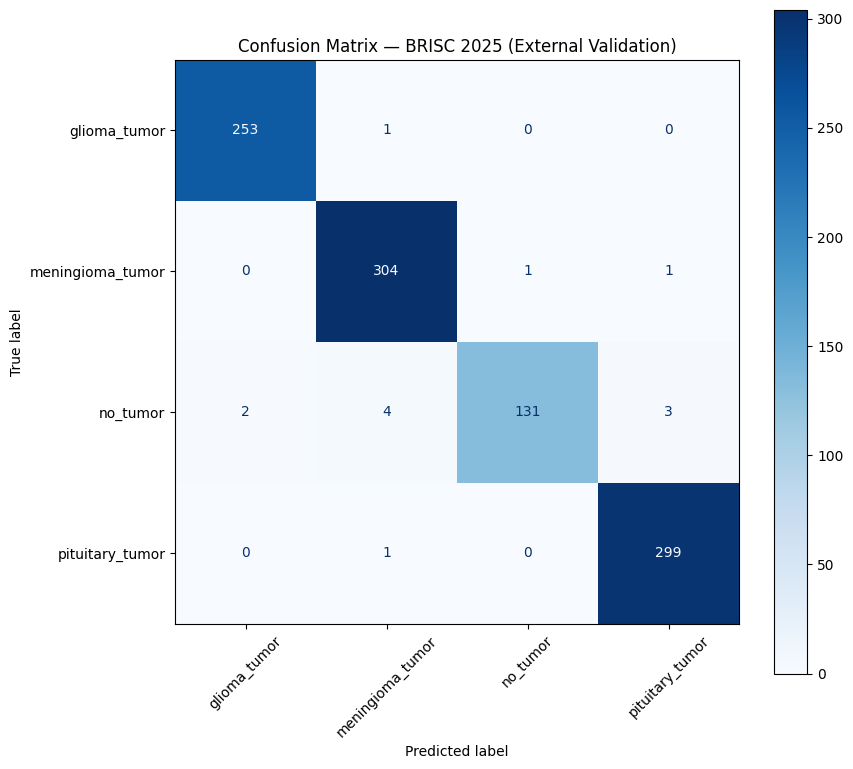

In [ ]:
# =========================================================
# EXTERNAL VALIDATION: BRISC 2025
# =========================================================

import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ---------------------------------------------------------
# CONFIG (CHANGE THESE ONLY)
# ---------------------------------------------------------
BRISC_ROOT = "//kaggle/input/brisc2025/brisc2025/classification_task/test"   # BRISC dataset root
CKPT_PATH  = "/kaggle/working/journal_brats_pretrain_finetune/best_finetuned.pt"

BATCH_SIZE = 32
NUM_WORKERS = 2

CLASS_ORDER = [
    'glioma_tumor',
    'meningioma_tumor',
    'no_tumor',
    'pituitary_tumor'
]
NUM_CLASSES = len(CLASS_ORDER)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# SAME TEST TRANSFORMS AS TRAINING
# ---------------------------------------------------------
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# ---------------------------------------------------------
# CLASS NAME NORMALIZATION (VERY IMPORTANT)
# ---------------------------------------------------------
def normalize_class(name: str) -> str:
    n = name.lower().strip()
    n = n.replace(" ", "_").replace("-", "_")

    mapping = {
        "glioma": "glioma_tumor",
        "glioma_tumor": "glioma_tumor",
        "meningioma": "meningioma_tumor",
        "meningioma_tumor": "meningioma_tumor",
        "pituitary": "pituitary_tumor",
        "pituitary_tumor": "pituitary_tumor",
        "no_tumor": "no_tumor",
        "notumor": "no_tumor",
        "normal": "no_tumor",
        "healthy": "no_tumor",
    }
    return mapping.get(n, None)

# ---------------------------------------------------------
# BRISC DATASET
# ---------------------------------------------------------
class BRISCDataset(Dataset):
    def __init__(self, root_dir, transform, class_order):
        self.samples = []
        self.transform = transform
        self.class_order = class_order

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            canon = normalize_class(folder)
            if canon is None or canon not in class_order:
                continue

            for fn in os.listdir(folder_path):
                if fn.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):
                    self.samples.append((os.path.join(folder_path, fn), canon))

        if len(self.samples) == 0:
            raise RuntimeError("No valid images found in BRISC dataset")

        # Print distribution
        counts = {c: 0 for c in class_order}
        for _, c in self.samples:
            counts[c] += 1
        print("BRISC class distribution:", counts)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fp, cls = self.samples[idx]
        img = Image.open(fp).convert("RGB")
        img = self.transform(img)
        label = self.class_order.index(cls)
        return img, label

# ---------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------
brisc_dataset = BRISCDataset(
    root_dir=BRISC_ROOT,
    transform=val_test_transform,
    class_order=CLASS_ORDER
)

brisc_loader = DataLoader(
    brisc_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ---------------------------------------------------------
# LOAD MODEL
# IMPORTANT: Proposed_Model MUST be defined above
# ---------------------------------------------------------
model = Proposed_Model(
    num_classes=NUM_CLASSES,
    in_ch=3,
    base_c=48
).to(device)

ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt.get("model_state", ckpt)

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"Checkpoint loaded | Missing={len(missing)} Unexpected={len(unexpected)}")

model.eval()

# ---------------------------------------------------------
# EVALUATION
# ---------------------------------------------------------
all_logits, all_labels = [], []

with torch.no_grad():
    for images, labels in brisc_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images, return_guidance=False, return_uncertainty=False)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels)

preds = logits.argmax(dim=1).numpy()
y_true = labels.numpy()
probs = torch.softmax(logits, dim=1).numpy()

# Metrics
acc = accuracy_score(y_true, preds)
prec = precision_score(y_true, preds, average="macro", zero_division=1)
rec = recall_score(y_true, preds, average="macro", zero_division=1)
f1 = f1_score(y_true, preds, average="macro", zero_division=1)

try:
    y_oh = F.one_hot(torch.tensor(y_true), NUM_CLASSES).numpy()
    auc = roc_auc_score(y_oh, probs, average="macro", multi_class="ovr")
except:
    auc = 0.0

print("\n" + "="*80)
print("EXTERNAL VALIDATION RESULTS — BRISC 2025")
print("="*80)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print("="*80)

# ---------------------------------------------------------
# CONFUSION MATRIX
# ---------------------------------------------------------
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_ORDER)

fig, ax = plt.subplots(figsize=(9, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — BRISC 2025 (External Validation)")
plt.tight_layout()
plt.show()

Device: cuda
BRISC class distribution: {'glioma_tumor': 755, 'meningioma_tumor': 546, 'no_tumor': 487, 'pituitary_tumor': 626}
Checkpoint loaded | Missing=0 Unexpected=0

EXTERNAL VALIDATION RESULTS — Mendeley Data 2025
Accuracy : 0.9354
Precision: 0.9346
Recall   : 0.9425
F1-score : 0.9343
AUC      : 0.9761


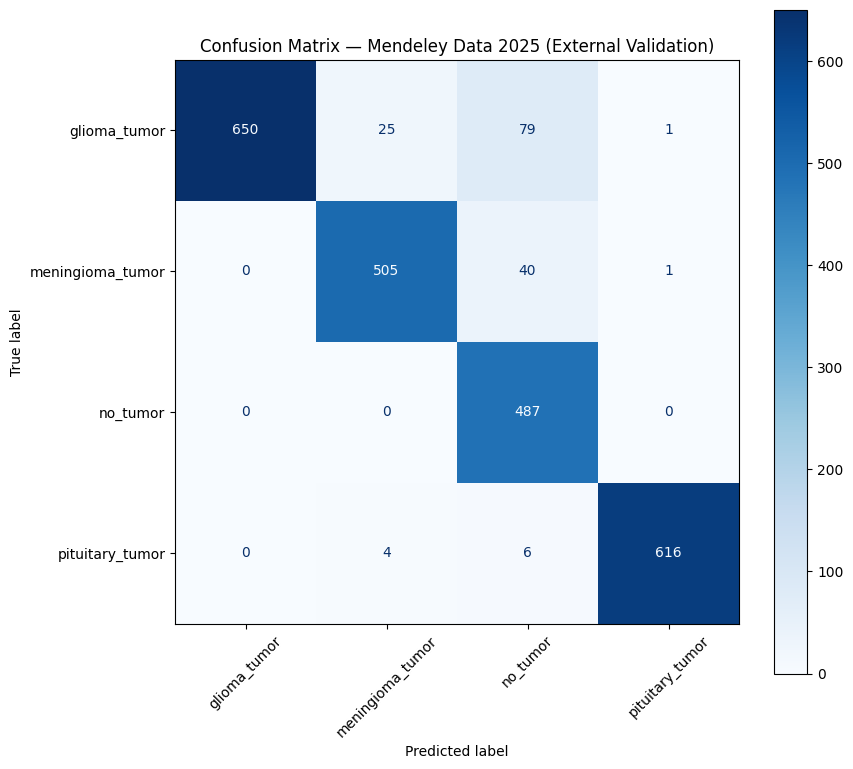

In [ ]:
# =========================================================
# EXTERNAL VALIDATION: BRISC 2025
# =========================================================

import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ---------------------------------------------------------
# CONFIG (CHANGE THESE ONLY)
# ---------------------------------------------------------
BRISC_ROOT = "/kaggle/input/brain-tumor-classification-mri/Epic and CSCR hospital Dataset/Test"   # BRISC dataset root
CKPT_PATH  = "/kaggle/working/journal_brats_pretrain_finetune/best_finetuned.pt"

BATCH_SIZE = 32
NUM_WORKERS = 2

CLASS_ORDER = [
    'glioma_tumor',
    'meningioma_tumor',
    'no_tumor',
    'pituitary_tumor'
]
NUM_CLASSES = len(CLASS_ORDER)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# SAME TEST TRANSFORMS AS TRAINING
# ---------------------------------------------------------
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# ---------------------------------------------------------
# CLASS NAME NORMALIZATION (VERY IMPORTANT)
# ---------------------------------------------------------
def normalize_class(name: str) -> str:
    n = name.lower().strip()
    n = n.replace(" ", "_").replace("-", "_")

    mapping = {
        "glioma": "glioma_tumor",
        "glioma_tumor": "glioma_tumor",
        "meningioma": "meningioma_tumor",
        "meningioma_tumor": "meningioma_tumor",
        "pituitary": "pituitary_tumor",
        "pituitary_tumor": "pituitary_tumor",
        "no_tumor": "no_tumor",
        "notumor": "no_tumor",
        "normal": "no_tumor",
        "healthy": "no_tumor",
    }
    return mapping.get(n, None)

# ---------------------------------------------------------
# BRISC DATASET
# ---------------------------------------------------------
class BRISCDataset(Dataset):
    def __init__(self, root_dir, transform, class_order):
        self.samples = []
        self.transform = transform
        self.class_order = class_order

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            canon = normalize_class(folder)
            if canon is None or canon not in class_order:
                continue

            for fn in os.listdir(folder_path):
                if fn.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):
                    self.samples.append((os.path.join(folder_path, fn), canon))

        if len(self.samples) == 0:
            raise RuntimeError("No valid images found in BRISC dataset")

        # Print distribution
        counts = {c: 0 for c in class_order}
        for _, c in self.samples:
            counts[c] += 1
        print("BRISC class distribution:", counts)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fp, cls = self.samples[idx]
        img = Image.open(fp).convert("RGB")
        img = self.transform(img)
        label = self.class_order.index(cls)
        return img, label

# ---------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------
brisc_dataset = BRISCDataset(
    root_dir=BRISC_ROOT,
    transform=val_test_transform,
    class_order=CLASS_ORDER
)

brisc_loader = DataLoader(
    brisc_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ---------------------------------------------------------
# LOAD MODEL
# IMPORTANT: Proposed_Model MUST be defined above
# ---------------------------------------------------------
model = Proposed_Model(
    num_classes=NUM_CLASSES,
    in_ch=3,
    base_c=48
).to(device)

ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt.get("model_state", ckpt)

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"Checkpoint loaded | Missing={len(missing)} Unexpected={len(unexpected)}")

model.eval()

# ---------------------------------------------------------
# EVALUATION
# ---------------------------------------------------------
all_logits, all_labels = [], []

with torch.no_grad():
    for images, labels in brisc_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images, return_guidance=False, return_uncertainty=False)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels)

preds = logits.argmax(dim=1).numpy()
y_true = labels.numpy()
probs = torch.softmax(logits, dim=1).numpy()

# Metrics
acc = accuracy_score(y_true, preds)
prec = precision_score(y_true, preds, average="macro", zero_division=1)
rec = recall_score(y_true, preds, average="macro", zero_division=1)
f1 = f1_score(y_true, preds, average="macro", zero_division=1)

try:
    y_oh = F.one_hot(torch.tensor(y_true), NUM_CLASSES).numpy()
    auc = roc_auc_score(y_oh, probs, average="macro", multi_class="ovr")
except:
    auc = 0.0

print("\n" + "="*80)
print("EXTERNAL VALIDATION RESULTS — Mendeley Data 2025")
print("="*80)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print("="*80)

# ---------------------------------------------------------
# CONFUSION MATRIX
# ---------------------------------------------------------
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_ORDER)

fig, ax = plt.subplots(figsize=(9, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — Mendeley Data 2025 (External Validation)")
plt.tight_layout()
plt.show()

Device: cuda
BRISC class distribution: {'glioma_tumor': 1208, 'meningioma_tumor': 930, 'no_tumor': 831, 'pituitary_tumor': 992}
Checkpoint loaded | Missing=0 Unexpected=0

EXTERNAL VALIDATION RESULTS — Brain MRI ND5 2025
Accuracy : 0.9732
Precision: 0.9720
Recall   : 0.9767
F1-score : 0.9738
AUC      : 0.9952


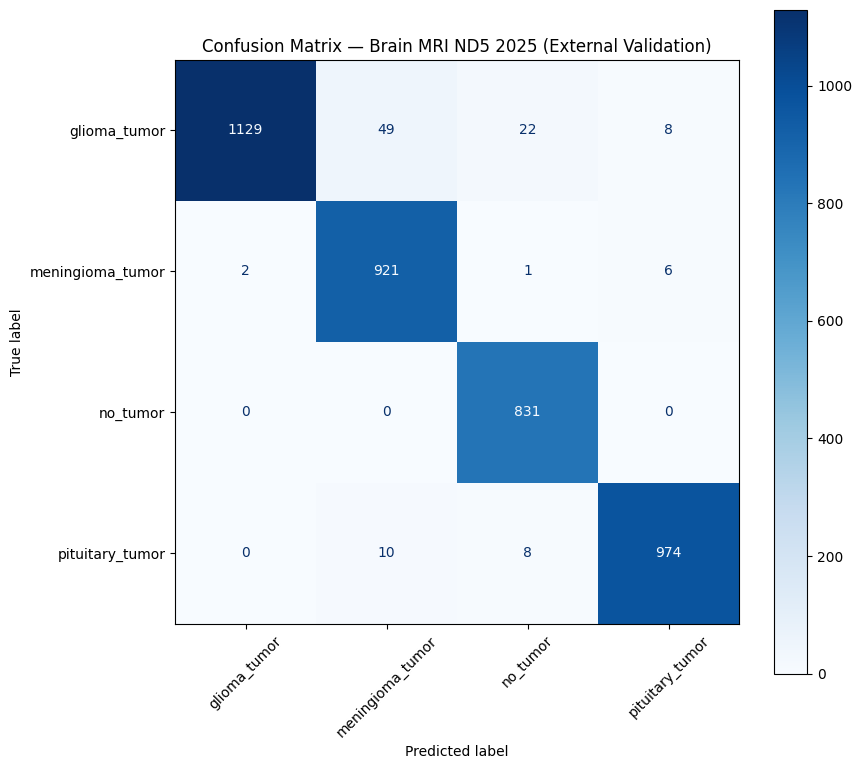

In [ ]:
# =========================================================
# EXTERNAL VALIDATION: BRISC 2025
# =========================================================

import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ---------------------------------------------------------
# CONFIG (CHANGE THESE ONLY)
# ---------------------------------------------------------
BRISC_ROOT = "/kaggle/input/brain-tumor-data-18k/tumordata/Testing"   # BRISC dataset root
CKPT_PATH  = "/kaggle/working/journal_brats_pretrain_finetune/best_finetuned.pt"

BATCH_SIZE = 32
NUM_WORKERS = 2

CLASS_ORDER = [
    'glioma_tumor',
    'meningioma_tumor',
    'no_tumor',
    'pituitary_tumor'
]
NUM_CLASSES = len(CLASS_ORDER)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# SAME TEST TRANSFORMS AS TRAINING
# ---------------------------------------------------------
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# ---------------------------------------------------------
# CLASS NAME NORMALIZATION (VERY IMPORTANT)
# ---------------------------------------------------------
def normalize_class(name: str) -> str:
    n = name.lower().strip()
    n = n.replace(" ", "_").replace("-", "_")

    mapping = {
        "glioma": "glioma_tumor",
        "glioma_tumor": "glioma_tumor",
        "meningioma": "meningioma_tumor",
        "meningioma_tumor": "meningioma_tumor",
        "pituitary": "pituitary_tumor",
        "pituitary_tumor": "pituitary_tumor",
        "no_tumor": "no_tumor",
        "notumor": "no_tumor",
        "normal": "no_tumor",
        "healthy": "no_tumor",
    }
    return mapping.get(n, None)

# ---------------------------------------------------------
# BRISC DATASET
# ---------------------------------------------------------
class BRISCDataset(Dataset):
    def __init__(self, root_dir, transform, class_order):
        self.samples = []
        self.transform = transform
        self.class_order = class_order

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            canon = normalize_class(folder)
            if canon is None or canon not in class_order:
                continue

            for fn in os.listdir(folder_path):
                if fn.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):
                    self.samples.append((os.path.join(folder_path, fn), canon))

        if len(self.samples) == 0:
            raise RuntimeError("No valid images found in BRISC dataset")

        # Print distribution
        counts = {c: 0 for c in class_order}
        for _, c in self.samples:
            counts[c] += 1
        print("BRISC class distribution:", counts)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fp, cls = self.samples[idx]
        img = Image.open(fp).convert("RGB")
        img = self.transform(img)
        label = self.class_order.index(cls)
        return img, label

# ---------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------
brisc_dataset = BRISCDataset(
    root_dir=BRISC_ROOT,
    transform=val_test_transform,
    class_order=CLASS_ORDER
)

brisc_loader = DataLoader(
    brisc_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ---------------------------------------------------------
# LOAD MODEL
# IMPORTANT: Proposed_Model MUST be defined above
# ---------------------------------------------------------
model = Proposed_Model(
    num_classes=NUM_CLASSES,
    in_ch=3,
    base_c=48
).to(device)

ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt.get("model_state", ckpt)

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"Checkpoint loaded | Missing={len(missing)} Unexpected={len(unexpected)}")

model.eval()

# ---------------------------------------------------------
# EVALUATION
# ---------------------------------------------------------
all_logits, all_labels = [], []

with torch.no_grad():
    for images, labels in brisc_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images, return_guidance=False, return_uncertainty=False)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels)

preds = logits.argmax(dim=1).numpy()
y_true = labels.numpy()
probs = torch.softmax(logits, dim=1).numpy()

# Metrics
acc = accuracy_score(y_true, preds)
prec = precision_score(y_true, preds, average="macro", zero_division=1)
rec = recall_score(y_true, preds, average="macro", zero_division=1)
f1 = f1_score(y_true, preds, average="macro", zero_division=1)

try:
    y_oh = F.one_hot(torch.tensor(y_true), NUM_CLASSES).numpy()
    auc = roc_auc_score(y_oh, probs, average="macro", multi_class="ovr")
except:
    auc = 0.0

print("\n" + "="*80)
print("EXTERNAL VALIDATION RESULTS — Brain MRI ND5 2025")
print("="*80)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")
print("="*80)

# ---------------------------------------------------------
# CONFUSION MATRIX
# ---------------------------------------------------------
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_ORDER)

fig, ax = plt.subplots(figsize=(9, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — Brain MRI ND5 2025 (External Validation)")
plt.tight_layout()
plt.show()